# Import Library

In [1]:
!pip install pyvi
!pip install python-Levenshtein
!apt-get update
!apt-get install -y hunspell libhunspell-dev
!pip install hunspell
!pip install vncorenlp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 18.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 1.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.7 MB/s eta 0:00:00:00:0100:01
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,939 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]           
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/m

In [2]:
import os
import warnings
import re
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from pyvi import ViTokenizer
from Levenshtein import distance as levenshtein_distance  # pip install python-Levenshtein
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

import hunspell  


2025-08-25 07:06:11.672635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756105571.877769      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756105571.933339      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!apt-get install -y hunspell hunspell-en-us hunspell-vi
!pip install hunspell

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
hunspell-en-us is already the newest version (1:2020.12.07-2).
hunspell-en-us set to manually installed.
hunspell is already the newest version (1.7.0-4build1).
Suggested packages:
  libreoffice-writer
The following NEW packages will be installed:
  hunspell-vi
0 upgraded, 1 newly installed, 0 to remove and 137 not upgraded.
Need to get 57.7 kB of archives.
After this operation, 449 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 hunspell-vi all 1:7.2.0-2 [57.7 kB]
Fetched 57.7 kB in 1s (55.5 kB/s)      
Selecting previously unselected package hunspell-vi.
(Reading database ... 128780 files and directories currently installed.)
Preparing to unpack .../hunspell-vi_1%3a7.2.0-2_all.deb ...
Unpacking hunspell-vi (1:7.2.0-2) ...
Setting up hunspell-vi (1:7.2.0-2) ...
Processing triggers for dictionaries-common (1.28.14) ...


In [4]:
import hunspell

# Tạo đối tượng từ gói hunspell, mặc định sẽ dùng dictionary hệ thống
h = hunspell.HunSpell('/usr/share/hunspell/vi_VN.dic', '/usr/share/hunspell/vi_VN.aff')

# Prepare Data

In [5]:
file_path = '/kaggle/input/data123/data.csv'

df=pd.read_csv(file_path)

display(df.head())



,comment,label,rate,Unnamed: 3
0,Áo bao đẹp ạ!!,POS,5,NaN
1,Tuyệt vời !,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN


# Data Exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment     31460 non-null  object
 1   label       31460 non-null  object
 2   rate        31460 non-null  int64 
 3   Unnamed: 3  23 non-null     object
dtypes: int64(1), object(3)
memory usage: 983.3+ KB


In [7]:
df.columns

Index(['comment', 'label', 'rate', 'Unnamed: 3'], dtype='object')

In [8]:
df.shape

(31460, 4)

In [9]:
df.isna().sum()

comment           0
label             0
rate              0
Unnamed: 3    31437
dtype: int64

In [10]:
df.duplicated().sum()

3982

In [11]:
df.describe(include = 'object').T

,count,unique,top,freq
comment,31460,26803,Chất lượng sản phẩm tuyệt vời.,536
label,31460,3,POS,20093
Unnamed: 3,23,1,*,23


# Exploratory Data Analysis (EDA)

# Barchar

In [12]:
print( df['label'].value_counts())

label
POS    20093
NEG     6669
NEU     4698
Name: count, dtype: int64


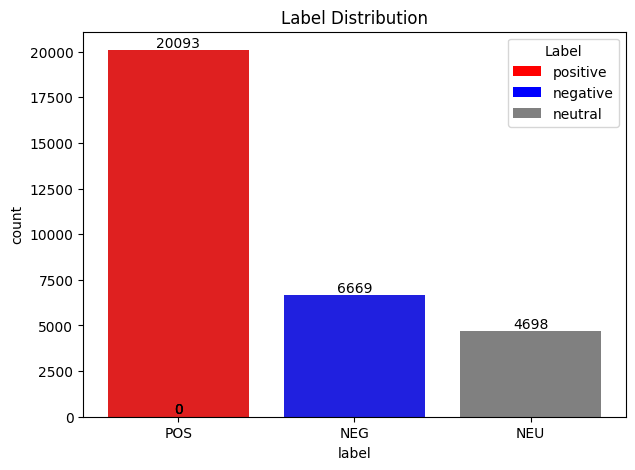

In [13]:


plt.figure(figsize=(7,5))

colors = ["red", "blue", "grey"]  
labels = ["positive", "negative", "neutral"]

ax = sns.countplot(
    x='label',
    data=df,
    palette=colors
)

plt.title("Label Distribution")

for label, color in zip(labels, colors):
    plt.bar(0, 0, color=color, label=label)  

plt.legend(title="Label", loc="upper right")


for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',                      
        (p.get_x() + p.get_width() / 2, height), 
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()


# PieChar

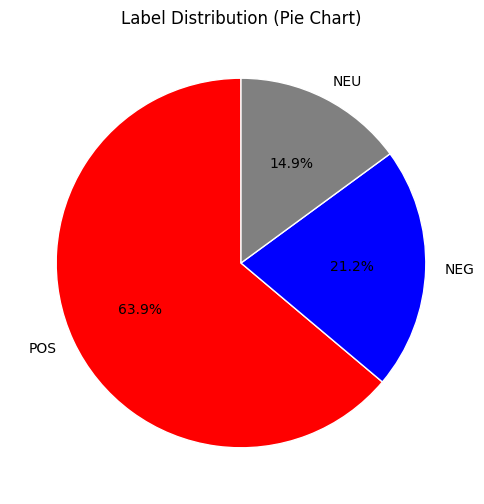

In [14]:

# Đếm số lượng từng nhãn
label_counts = df['label'].value_counts()

# Màu giống như bar chart
colors = ["red", "blue", "grey"]

# Vẽ pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct='%1.1f%%',  # hiện phần trăm
    startangle=90,      # xoay biểu đồ để bắt đầu từ trên
    colors=colors,
    wedgeprops={'edgecolor': 'white'}  # viền trắng
)

plt.title("Label Distribution (Pie Chart)")
plt.show()


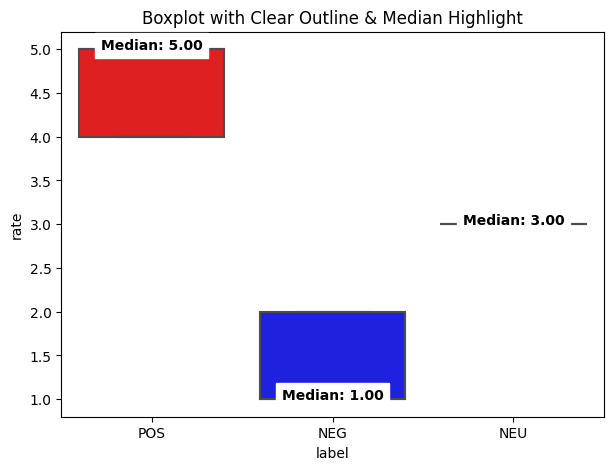

In [15]:

plt.figure(figsize=(7,5))
ax = sns.boxplot(
    x='label',
    y='rate',
    data=df,
    order=["POS", "NEG", "NEU"],
    palette={"POS": "red", "NEG": "blue", "NEU": "grey"},      # viền nắp       # đường trung vị
)

medians = df.groupby('label')['rate'].median().reindex(["POS", "NEG", "NEU"]).values

for i, median in enumerate(medians):
    ax.text(
        i,                  
        median,             
        f'Median: {median:.2f}',   # Thêm chữ Median
        horizontalalignment='center',
        color='black',
        weight='bold',
        backgroundcolor='white'
    )


plt.title("Boxplot with Clear Outline & Median Highlight")
plt.show()


# Clean Data

In [16]:
tf = df.copy()

tf.head()

,comment,label,rate,Unnamed: 3
0,Áo bao đẹp ạ!!,POS,5,NaN
1,Tuyệt vời !,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN


# Remove column Unnamed: 3

In [17]:
tf.drop(columns=["Unnamed: 3"], inplace=True)

tf.head()


,comment,label,rate
0,Áo bao đẹp ạ!!,POS,5
1,Tuyệt vời !,POS,5
2,2day ao khong giong trong.,NEG,1
3,"Mùi thơm,bôi lên da mềm da.",POS,5
4,"Vải đẹp, dày dặn.",POS,5


In [18]:

def CleanText(text):
    if not isinstance(text, str):
        return ""
    
   
    text = emoji.replace_emoji(text, replace='')

    
    text = re.sub(r'[^\w\s!?]', ' ', text, flags=re.UNICODE)

   
    text = re.sub(r'\s+', ' ', text).strip()

    
    text = text.lower()

    return text

sample_text = "Áo bao đẹp ạ!!	"
cleaned = CleanText(sample_text)
print(cleaned)

áo bao đẹp ạ!!


In [19]:
tf["comment"] = tf["comment"].apply(CleanText)

In [56]:
tf.head(20)

,comment,label,rate
0,áo bao đẹp ạ!!,POS,5
1,tuyệt vời !,POS,5
2,2day ao khong giong trong,NEG,1
3,mùi thơm bôi lên da mềm da,POS,5
4,vải đẹp dày dặn,POS,5
5,hàng rất đẹp rất chi là ưng ý,POS,5
6,chất lượng sản phẩm tốt date dài,POS,5
7,ăn nói và thái độ phục vụ tốt,POS,4
8,đóng gói sản phẩm chắc chắn,POS,5
9,tất sờn hết ca chưa dùng mà vay r,NEG,2


In [21]:
tf.isna().sum()

comment    0
label      0
rate       0
dtype: int64

In [22]:
tf.drop_duplicates(subset=['comment'])

,comment,label,rate
0,áo bao đẹp ạ!!,POS,5
1,tuyệt vời !,POS,5
2,2day ao khong giong trong,NEG,1
3,mùi thơm bôi lên da mềm da,POS,5
4,vải đẹp dày dặn,POS,5
...,...,...,...
31452,chất tốt shop phục vụ rất tốt,POS,5
31454,hàng y hình đóng gói ko cẩn thận nên quả ngực ...,NEU,3
31457,hàng đẹp đúng giá tiền,POS,5
31458,chất vải khá ổn,POS,4


In [23]:
tf.duplicated().sum()

4924

In [24]:
tf.shape

(31460, 3)

In [25]:
tf_unique = tf.drop_duplicates(subset=['comment'])

tf_unique.duplicated().sum()

0

In [26]:
tf_unique.shape

(25733, 3)

# Check Spell

In [27]:
import hunspell

# Tạo đối tượng từ gói hunspell, mặc định sẽ dùng dictionary hệ thống
h = hunspell.HunSpell('/usr/share/hunspell/vi_VN.dic', '/usr/share/hunspell/vi_VN.aff')

print(h.spell("xin"))       # True
print(h.spell("xinh"))      # True
print(h.spell("xinn"))      # False
print(h.suggest("xinn"))    # ['xinh', 'xin', 'xịn']

True
True
False
['xin', 'xinh']


In [28]:
def find_misspelled_words(text):
    """Trả về danh sách các từ sai chính tả trong một câu."""
    if not isinstance(text, str):
        return []
    words = text.split()
    misspelled = [word for word in words if not h.spell(word)]
    return misspelled

# Hàm duyệt toàn bộ cột comment của DataFrame
def find_all_misspelled(df, column='comment'):
    """Trả về danh sách tất cả các từ sai chính tả trong df[column]"""
    all_misspelled = []
    for text in df[column]:
        all_misspelled.extend(find_misspelled_words(text))
    # Loại trùng lặp nếu muốn
    all_misspelled = list(set(all_misspelled))
    return all_misspelled

misspelled_words = find_all_misspelled(tf_unique, 'comment')
print("Danh sách các từ sai chính tả:", misspelled_words)

Danh sách các từ sai chính tả: ['rôi', 'hqua', 'jean', 'bestttt', 'ránh', 'ck', 'lươing', 'yêuu', '50lg', 'đựơc', 'seza', 'fr', 'iphone', 'clothes', 'gém', 'wam', 'dings', 'môg', 'gét', 'pastel', '8k', 'nhê', 'huhh', 'vn', 'ạ!!', 'qả', 'haj', 'đep!', 'burgundy', 'đy', 'rap', 'chuc', '1m58', 'vãy', 'via', 'rôbgj', 'color', 'sze', 'm55', '1m5', 'ship', 'cute!!', 'truớc', 'hing', 'v1', 'àk', 'sizze', 'oto', 'đoáaaaa', 'í!', '165k', 'đccảnh', 'giad', '2phân', 'luôn!!!!', 'hoạtđược', 'xịnnnn', 'zớt', 'idol', 'xinhhhhh', 'nữa!!', 'đáng!', 'tọa', '1chiếc', 'ahihi', 'xanhgiaonhâ', 'luôn?', 'evoucher', 'nản!', 'đủ!', 'inb', 'instagram', 'simply', 'hếtok', 'có!', '3chai', 'shop!!!', 'times', 'đckh', 'ta0', 'okkee', 'đợi!!!', 'vuc', 'lavender', 'okk', 'public', 'xưât', 'buc', 'shope', 'giưa', 't9', 'replica', 'bn', 'shit', 'swensen', 'jaen', 'oki', 'digi', 'họa', '2size', 'luờn', 'vờin', 'good!', 'on', 'x', 'totts', 'độg', 'nhau7', 'mà?', 'packing', 'thích!!!!', '75w', 'vưaf', 'mieu', '??', 'loai

In [29]:

def correct_word(word):
    # 1. Xử lý double ký tự: thikk -> thik
    word = re.sub(r'(.)\1+', r'\1', word)

    # 2. Kiểm tra Hunspell
    if h.spell(word):
        return word

    # 3. Lấy gợi ý và chọn từ gần nhất
    suggestions = h.suggest(word)
    if suggestions:
        # Chọn từ có khoảng cách Levenshtein nhỏ nhất
        closest = min(suggestions, key=lambda w: levenshtein_distance(word, w))
        return closest

    # 4. Nếu không có gợi ý, giữ nguyên
    return word

def correct_text(text):
    return " ".join(correct_word(w) for w in text.split())


text = "okee"
corrected_text = correct_text(text)
print(corrected_text)


oe


In [30]:
tf_unique['comment'] = tf_unique['comment'].apply(correct_text)

misspelled_words = find_all_misspelled(tf_unique, 'comment')
print("Danh sách các từ sai chính tả hoặc tiếng anh:", misspelled_words)


Danh sách các từ sai chính tả hoặc tiếng anh: ['win7', '5c', 'aex', 'jean', 'bluetoth', 'motor', '50lg', '7kg', 'voucher', 'jeans', 'ships', 'shop10', '43kg', 'fr', 'clothes', 'loveyou', 'pastel', '8k', 'tks', 'jeny', 'silicon', 'fel', 'black', '8l', 'binhthuong', 'burgundy', '43kí', 'shopy', '159k', '1m58', 'color', 'buble', 'k98', '1m5', 'like!', '75kg', 'dethuog', 'hsd?', 'pizama', '15h', 'leoshop', 'ful', 'artemia', '165k', 'hidentag', '13h30', 'shope?', 'kokie', '5sp', 'zaka', 'cute!', 'digiworld', 'hoangyengan', 'm63', 'flashcard', 'service', '52k', 'ahihi', 'xanhgiaonhâ', 'm24', '2h30p', 'evoucher', '37kg', 'flashsale', 'reset', 'instagram', 'f1', 'flash', 'kisprof', '75b', 'godlắm', 'yeah', '58kí', '3c', 'adidas', 'vnxk?', 'mornaga', 'fabric', '25x2', 'ahuhu', '45kg', 'remote', '3h', 'lavender', 'public', '1m52', 'shope', 'face', '24t', 'replica', 'swensen', 'jaen', '2size', '57kg', '75k', '63k', '3k', 'jeasn', '3xl', 'm62', 'pamper', 'packing', '75w', '1m67', 'joy', '8c', '1m6

/tmp/ipykernel_36/2307397825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_unique['comment'] = tf_unique['comment'].apply(correct_text)


In [31]:
tf_unique.shape

(25733, 3)

In [32]:
##from pyvi import ViTokenizer 
##tf_unique["comment"] = tf_unique["comment"].apply(lambda x : ViTokenizer.tokenize(x))

In [33]:
from sklearn.preprocessing import LabelEncoder


encoder=LabelEncoder()

tf_unique['label']=encoder.fit_transform(tf_unique['label'])

tf_unique.head(20)

/tmp/ipykernel_36/339040208.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_unique['label']=encoder.fit_transform(tf_unique['label'])


,comment,label,rate
0,áo bao đẹp ạ,2,5
1,tuyệt vời a,2,5
2,day ao khòng giong trong,0,1
3,mùi thơm bôi lên da mềm da,2,5
4,vải đẹp dày dặn,2,5
5,hàng rất đẹp rất chi là ưng ý,2,5
6,chất lượng sản phẩm tốt da te dài,2,5
7,ăn nói và thái độ phục vụ tốt,2,4
8,đóng gói sản phẩm chắc chắn,2,5
9,tất sờn hết ca chưa dùng mà vay e,0,2


# Removing Stopword

In [34]:
with open("/kaggle/input/dictionary/vietnamese-stopwords-dash.txt", "r", encoding="utf-8") as f:
    stopwords = set(f.read().splitlines())

In [35]:
print(stopwords)

{'tuy', 'chợt', 'chúng', 'cuối', 'bạn', 'cả_nghe', 'vài_điều', 'tháng_tháng', 'nhất', 'dù_cho', 'chưa_dùng', 'ứ_hự', 'bất_kỳ', 'sáng', 'thẩy', 'số_là', 'đã_hay', 'có_thể', 'cũng_nên', 'làm_đúng', 'thuộc_lại', 'lại_giống', 'ăn_quá', 'đặt_mức', 'thì_là', 'mày', 'cho_biết', 'cho_tới_khi', 'bỏ', 'là_nhiều', 'dễ_ăn', 'đủ_dùng', 'thoạt', 'hay_làm', 'anh', 'lượng', 'cóc_khô', 'vào', 'tăng_cấp', 'đầy', 'thực_ra', 'lúc_khác', 'thanh_không', 'tốc_tả', 'rồi_ra', 'thoắt', 'bây_giờ', 'vèo', 'đến_hay', 'dần_dà', 'ở_trên', 'tạo', 'chú_khách', 'sao_đang', 'ông_tạo', 'càng', 'bỗng_chốc', 'chung_ái', 'ngay_bây_giờ', 'con_con', 'thế_lại', 'cật_lực', 'chăng_nữa', 'cho_hay', 'cơ_chỉ', 'càng_hay', 'càng_càng', 'thím', 'đây', 'sau_đây', 'nghe_như', 'tiếp_tục', 'đã_không', 'cùng_cực', 'nhà_khó', 'tấm_bản', 'cảm_thấy', 'về_nước', 'mới', 'thì_giờ', 'tôi', 'nhận_làm', 'sau_này', 'tựu_trung', 'nào', 'nhà_tôi', 'đặt_trước', 'còn', 'đặt_mình', 'ngày_xưa', 'nào_phải', 'coi_mòi', 'bỗng', 'ra_điều', 'có_chứ', 'thôi_vi

In [36]:
def remove_stopwords(text):
    # Tách từ đơn giản (không tách tiếng Việt nâng cao)
    tokens = text.split()
    # Lọc từ không thuộc stopword
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords]
    return " ".join(filtered_tokens)

    
tf_unique['comment'] = tf_unique['comment'].apply(remove_stopwords)

/tmp/ipykernel_36/1608078358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_unique['comment'] = tf_unique['comment'].apply(remove_stopwords)


In [37]:
tf_unique.head(100)

,comment,label,rate
0,áo đẹp,2,5
1,tuyệt vời a,2,5
2,day ao khòng giong,0,1
3,mùi thơm bôi da mềm da,2,5
4,vải đẹp dày dặn,2,5
...,...,...,...
97,ốc hơi lỏng vặn vít ka nhiêu quý dây,1,3
99,pho phục vụ hết mẫu gọi đổi khác giá giá sa le...,2,5
100,ren hơi mềm dáng áo lo cứng nâng ngực tạm đa,2,4
101,giao hàng,0,2


# Modeling

In [38]:



train_texts, val_texts, train_labels, val_labels = train_test_split(
    tf_unique['comment'].tolist(),
    tf_unique['label'].tolist(),
    test_size=0.3,
    random_state=42
)


In [39]:
print("Train texts:", np.array(train_texts).shape)
print("Val texts:", np.array(val_texts).shape)
print("Train labels:", np.array(train_labels).shape)
print("Val labels:", np.array(val_labels).shape)

Train texts: (18013,)
Val texts: (7720,)
Train labels: (18013,)
Val labels: (7720,)


In [40]:

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

In [41]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

model_name = "FPTAI/vibert-base-cased"

# Load config và chỉnh dropout
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=len(encoder.classes_),
    hidden_dropout_prob=0.4,   # dropout trong hidden layers
    attention_probs_dropout_prob=0.4  # dropout trong attention
)

# Load model với config đã chỉnh
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

tokenizer = AutoTokenizer.from_pretrained(model_name)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/581M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at FPTAI/vibert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/581M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [42]:
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["text"])

val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=["text"])

Map:   0%|          | 0/18013 [00:00<?, ? examples/s]

Map:   0%|          | 0/7720 [00:00<?, ? examples/s]

In [43]:

train_dataset.shape

val_dataset.shape

(7720, 4)

In [44]:
train_dataset.set_format("torch")
val_dataset.set_format("torch")

In [45]:
import transformers
print(transformers.__version__)
print(transformers.TrainingArguments.__init__.__code__.co_varnames)

4.52.4
('self', 'output_dir', 'overwrite_output_dir', 'do_train', 'do_eval', 'do_predict', 'eval_strategy', 'prediction_loss_only', 'per_device_train_batch_size', 'per_device_eval_batch_size', 'per_gpu_train_batch_size', 'per_gpu_eval_batch_size', 'gradient_accumulation_steps', 'eval_accumulation_steps', 'eval_delay', 'torch_empty_cache_steps', 'learning_rate', 'weight_decay', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'max_grad_norm', 'num_train_epochs', 'max_steps', 'lr_scheduler_type', 'lr_scheduler_kwargs', 'warmup_ratio', 'warmup_steps', 'log_level', 'log_level_replica', 'log_on_each_node', 'logging_dir', 'logging_strategy', 'logging_first_step', 'logging_steps', 'logging_nan_inf_filter', 'save_strategy', 'save_steps', 'save_total_limit', 'save_safetensors', 'save_on_each_node', 'save_only_model', 'restore_callback_states_from_checkpoint', 'no_cuda', 'use_cpu', 'use_mps_device', 'seed', 'data_seed', 'jit_mode_eval', 'use_ipex', 'bf16', 'fp16', 'fp16_opt_level', 'half_precision_ba

In [46]:
import transformers
print(transformers.__version__)
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/kaggle/working/results",
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.5,
    max_grad_norm=1.0,
    logging_dir="./logs",
    learning_rate=1e-5, 
    lr_scheduler_type="linear",
    
   
    eval_strategy="epoch",          
    logging_strategy="epoch",     
    logging_first_step=True,      
    save_strategy="epoch",
    save_total_limit=2, 
    load_best_model_at_end=True,
    report_to="none"  
)


4.52.4


In [47]:
import matplotlib.pyplot as plt
from transformers import TrainerCallback

class LossHistoryCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_losses.append((state.epoch, logs["loss"]))
            if "eval_loss" in logs:
                self.eval_losses.append((state.epoch, logs["eval_loss"]))

loss_callback = LossHistoryCallback()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.918100,0.808484,0.663342,0.547601,0.663342,0.597942
2,0.769800,0.721619,0.704275,0.595548,0.704275,0.644905
3,0.726900,0.723430,0.714637,0.607238,0.714637,0.655500
4,0.698700,0.707976,0.720725,0.612614,0.720725,0.661070
5,0.681700,0.709092,0.720207,0.709703,0.720207,0.664661
6,0.667500,0.698416,0.727979,0.692109,0.727979,0.684243
7,0.656900,0.691647,0.730440,0.701139,0.730440,0.688198
8,0.648400,0.697396,0.730699,0.692682,0.730699,0.692984
9,0.641500,0.700351,0.731477,0.694389,0.731477,0.693314
10,0.635200,0.690621,0.730440,0.696082,0.730440,0.699866


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

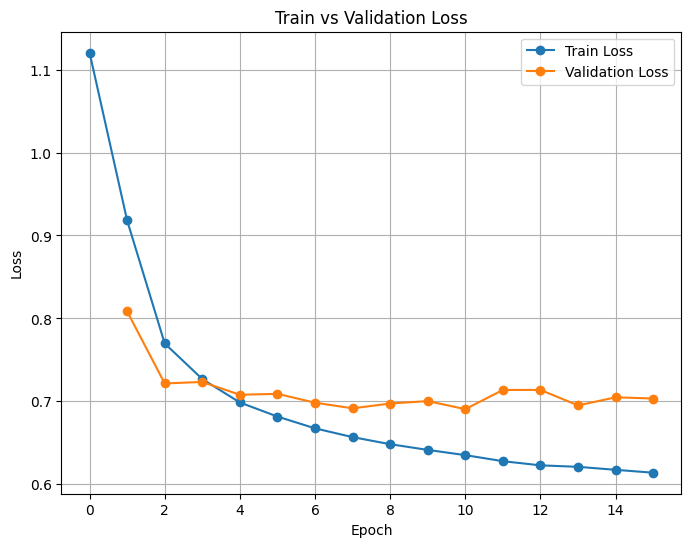

In [48]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    # Accuracy
    acc = accuracy_score(labels, preds)
    
    # Precision, Recall, F1 (nếu muốn log thêm)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }
    

# Trainer với EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=20),
        loss_callback
    ], 
)

trainer.train()


train_epochs, train_losses = zip(*loss_callback.train_losses)
eval_epochs, eval_losses = zip(*loss_callback.eval_losses)

plt.figure(figsize=(8, 6))
plt.plot(train_epochs, train_losses, label="Train Loss", marker="o")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



In [49]:
save_dir = "./sentiment_model"

trainer.save_model(save_dir)           # Lưu model
tokenizer.save_pretrained(save_dir)    # Lưu tokenizer

('./sentiment_model/tokenizer_config.json',
 './sentiment_model/special_tokens_map.json',
 './sentiment_model/vocab.txt',
 './sentiment_model/added_tokens.json',
 './sentiment_model/tokenizer.json')

In [58]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


model = AutoModelForSequenceClassification.from_pretrained(save_dir)
tokenizer = AutoTokenizer.from_pretrained(save_dir)


text = "sản phẩm chắc chắn"


inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)


with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)
    predicted_class_id = torch.argmax(probs, dim=-1).item()

print("Xác suất:", probs.numpy())
print("Dự đoán nhãn:", predicted_class_id)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Xác suất: [[0.3074936  0.23861293 0.45389345]]
Dự đoán nhãn: 2
